# 15 - TTI pure qP-wave equation implementation

The aim of this notebook is to show how to solve the pure qP-wave equation using the finite-difference (FD) scheme. The 2D TTI pure qP-wave equation can be written as ([Mu et al., 2020](https://library.seg.org/doi/10.1190/geo2019-0320.1))

$$
\begin{align}
\frac{1}{v_{p}^{2}}\frac{\partial^{2}p(\textbf{x},t)}{\partial t^{2}} = & \,\, (1+2\delta\sin^{2}\theta\cos^{2}\theta + 2\epsilon\cos^{4}\theta)\frac{\partial^{4}q(\textbf{x},t)}{\partial x^{4}} \nonumber \\
& + (1+2\delta\sin^{2}\theta\cos^{2}\theta + 2\epsilon\sin^{4}\theta)\frac{\partial^{4}q(\textbf{x},t)}{\partial z^{4}} \nonumber \\
&  + (2 - \delta\sin^{2}2\theta+3\epsilon\sin^{2}2\theta+2\delta\cos^{2}\theta)\frac{\partial^{4}q(\textbf{x},t)}{\partial x^{2}\partial z^{2}} \nonumber \\
& +(\delta\sin4\theta-4\epsilon\sin2\theta\cos^{2}\theta)\frac{\partial^4 q(\textbf{x},t)}{\partial x^{3}\partial z} \nonumber \\
& +(-\delta\sin4\theta-4\epsilon\sin2\theta\cos^{2}\theta)\frac{\partial^4 q(\textbf{x},t)}{\partial x\partial z^{3}} \nonumber \\
& + f(\textbf{x}_{s},t), \nonumber \\
\frac{\partial^{2}q(\textbf{x},t)}{\partial x^{2}} + \frac{\partial^{2}q(\textbf{x},t)}{\partial z^{2}} = & p(\textbf{x},t), \nonumber
\end{align}
$$

where $q(\textbf{x},t)$ is an auxiliary wavefield, which is introduced for implementing the FD scheme.

First of all, it is necessary to import some Devito modules and other packages that will be used in the implementation.

In [1]:
import numpy as np
from devito import (Function, TimeFunction, cos, sin, solve,
                    Eq, Operator)
from examples.seismic import TimeAxis, RickerSource, Receiver, demo_model
from matplotlib import pyplot as plt

We will start with the definitions of the grid and the physical parameters $v_{p}, \theta, \epsilon, \delta$. For simplicity, we won't use any absorbing boundary conditions to avoid reflections of outgoing waves at the boundaries of the computational domain, but we will have boundary conditions (zero Dirichlet) at $x=0,nx$ and $z=0,nz$ for the solution of the Poisson equation. We use a homogeneous model. The model is discretized with a grid of $101 \times 101$ and spacing of 10 m. The $v_{p}, \epsilon, \delta$ and $\theta$ parameters of this model are 3600 m∕s, 0.23, 0.17, and 45°, respectively. 

In [2]:
# NBVAL_IGNORE_OUTPUT

shape = (101, 101)  # 101x101 grid
spacing = (10., 10.)  # spacing of 10 meters
origin = (0., 0.)
nbl = 0  # number of pad points

model = demo_model('layers-tti', spacing=spacing, space_order=8,
                   shape=shape, nbl=nbl, nlayers=1)

# initialize Thomsem parameters to those used in Mu et al., (2020)
model.update('vp', np.ones(shape)*3.6)  # km/s
model.update('epsilon', np.ones(shape)*0.23)
model.update('delta', np.ones(shape)*0.17)
model.update('theta', np.ones(shape)*(45.*(np.pi/180.)))  # radians

In cell below, symbols used in the PDE definition are obtained from the `model` object. Note that trigonometric functions proper of Devito are exploited.

In [3]:
# Get symbols from model
theta = model.theta
delta = model.delta
epsilon = model.epsilon
m = model.m

# Use trigonometric functions from Devito
costheta = cos(theta)
sintheta = sin(theta)
cos2theta = cos(2*theta)
sin2theta = sin(2*theta)
sin4theta = sin(4*theta)

Accordingly to [Mu et al., (2020)](https://library.seg.org/doi/10.1190/geo2019-0320.1), the time sampling can be chosen as 
$$
\Delta t < \frac{\Delta d}{\pi \cdot (v_{p})_{max}}\sqrt{\dfrac{1}{(1+\eta_{max}|\cos\theta-\sin\theta|_{max}^{2})}}
$$,

where $\eta_{max}$ denotes the maximum value between $|\epsilon|_{max}$ and $|\delta|_{max}$, $|cos\theta-sin\theta|_{max}$ is the maximum value of $|cos\theta-sin\theta|$.

In [4]:
# NBVAL_IGNORE_OUTPUT

# Values used to compute the time sampling
epsilonmax = np.max(np.abs(epsilon.data[:]))
deltamax = np.max(np.abs(delta.data[:]))
etamax = max(epsilonmax, deltamax)
vmax = model._max_vp
max_cos_sin = np.amax(np.abs(np.cos(theta.data[:]) - np.sin(theta.data[:])))
dvalue = min(spacing)

The next step is to define the simulation time. It has to be small enough to avoid reflections from borders. Note we will use the `dt` computed below rather than the one provided by the property() function `critical_dt` in the `SeismicModel` class, as the latter only works for the coupled pseudoacoustic equation.

In [5]:
# Compute the dt and set time range
t0 = 0.   # Simulation time start
tn = 150.  # Simulation time end (0.15 second = 150 msec)
dt = (dvalue/(np.pi*vmax))*np.sqrt(1/(1+etamax*(max_cos_sin)**2))  # eq. above (cell 3)
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("time_range; ", time_range)

time_range;  TimeAxis: start=0, stop=150.313, step=0.884194, num=171


In exactly the same form as in the [Cavity flow with Navier-Stokes]() tutorial, we will use two operators, one for solving the Poisson equation in pseudotime and one for advancing in time. But unlike what was done in such tutorial, in this case, we write the FD solution of the poisson equation in a manually way, without using the `laplace` shortcut and `solve` functionality (just to break up the routine and try to vary). The internal time loop can be controlled by supplying the number of pseudotime steps (`niter_poisson` iterations) as a `time` argument to the operator. A Ricker wavelet source with peak frequency of 20 Hz is located at center of the model.

In [6]:
# NBVAL_IGNORE_OUTPUT

# time stepping
p = TimeFunction(name="p", grid=model.grid, time_order=2, space_order=2)
q = Function(name="q", grid=model.grid, space_order=8)

# Main equations
term1_p = (1 + 2*delta*(sintheta**2)*(costheta**2) + 2*epsilon*costheta**4)*q.dx4
term2_p = (1 + 2*delta*(sintheta**2)*(costheta**2) + 2*epsilon*sintheta**4)*q.dy4
term3_p = (2-delta*(sin2theta)**2 + 3*epsilon*(sin2theta)**2 + 2*delta*(cos2theta)**2)*((q.dy2).dx2)
term4_p = (delta*sin4theta - 4*epsilon*sin2theta*costheta**2)*((q.dy).dx3)
term5_p = (-delta*sin4theta - 4*epsilon*sin2theta*sintheta**2)*((q.dy3).dx)

stencil_p = solve(m*p.dt2 - (term1_p + term2_p + term3_p + term4_p + term5_p), p.forward)
update_p = Eq(p.forward, stencil_p)

# Poisson eq. (following notebook 6 from CFD examples)
b = Function(name='b', grid=model.grid, space_order=2)
pp = TimeFunction(name='pp', grid=model.grid, space_order=2)

# Create stencil and boundary condition expressions
x, z = model.grid.dimensions
t = model.grid.stepping_dim

update_q = Eq(pp[t+1, x, z], ((pp[t, x+1, z] + pp[t, x-1, z])*z.spacing**2 + (pp[t, x, z+1] + pp[t, x, z-1])*x.spacing**2 -
         b[x, z]*x.spacing**2*z.spacing**2) / (2*(x.spacing**2 + z.spacing**2)))

bc = [Eq(pp[t+1, x, 0], 0.)]
bc += [Eq(pp[t+1, x, shape[1]+2*nbl-1], 0.)]
bc += [Eq(pp[t+1, 0, z], 0.)]
bc += [Eq(pp[t+1, shape[0]-1+2*nbl, z], 0.)]

# set source and receivers
src = RickerSource(name='src', grid=model.grid, f0=0.02, npoint=1, time_range=time_range)
src.coordinates.data[:, 0] = model.domain_size[0]* .5
src.coordinates.data[:, 1] = model.domain_size[0]* .5
# Define the source injection
src_term = src.inject(field=p.forward, expr=src * dt**2 / m)

rec = Receiver(name='rec', grid=model.grid, npoint=shape[0], time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(model.origin[0], model.domain_size[0], num=model.shape[0])
rec.coordinates.data[:, 1] = 2*spacing[1]
# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=p.forward)

# Operators
optime = Operator([update_p] + src_term + rec_term)
oppres = Operator([update_q] + bc)

# you can print the generated code for both operators by typing print(optime) and print(oppres)

The time steps are advanced through a Python loop where both operators `optime` and `oppres`are called. Note the use of module indices to get proper buffers. We set the number of iteration `niter_poisson` for approximating the solution to Poisson equation as 1200.

In [7]:
# NBVAL_IGNORE_OUTPUT
psave = np.empty((time_range.num, model.grid.shape[0], model.grid.shape[1]))
niter_poisson = 1200

# This is the time loop.
for step in range(0, time_range.num-2):
    q.data[:, :] = pp.data[(niter_poisson+1) % 2, :, :]
    optime(time_m=step, time_M=step, dt=dt)
    pp.data[:, :] = 0.
    b.data[:, :] = p.data[(step+1) % 3, :, :]
    oppres(time_M=niter_poisson)
    psave[step, :, :] = p.data[(step+1) % 3, :, :]

Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.04 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.04 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.02 s


In [8]:
# Some useful definitions for plotting if nbl is set to any other value than zero
nxpad, nzpad = shape[0] + 2 * nbl, shape[1] + 2 * nbl
shape_pad = np.array(shape) + 2 * nbl
origin_pad = tuple([o - s*nbl for o, s in zip(origin, spacing)])
extent_pad = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

We can plot equally spaced snaps (by `factor`) from the full history saved in `psave` using matplotlib.

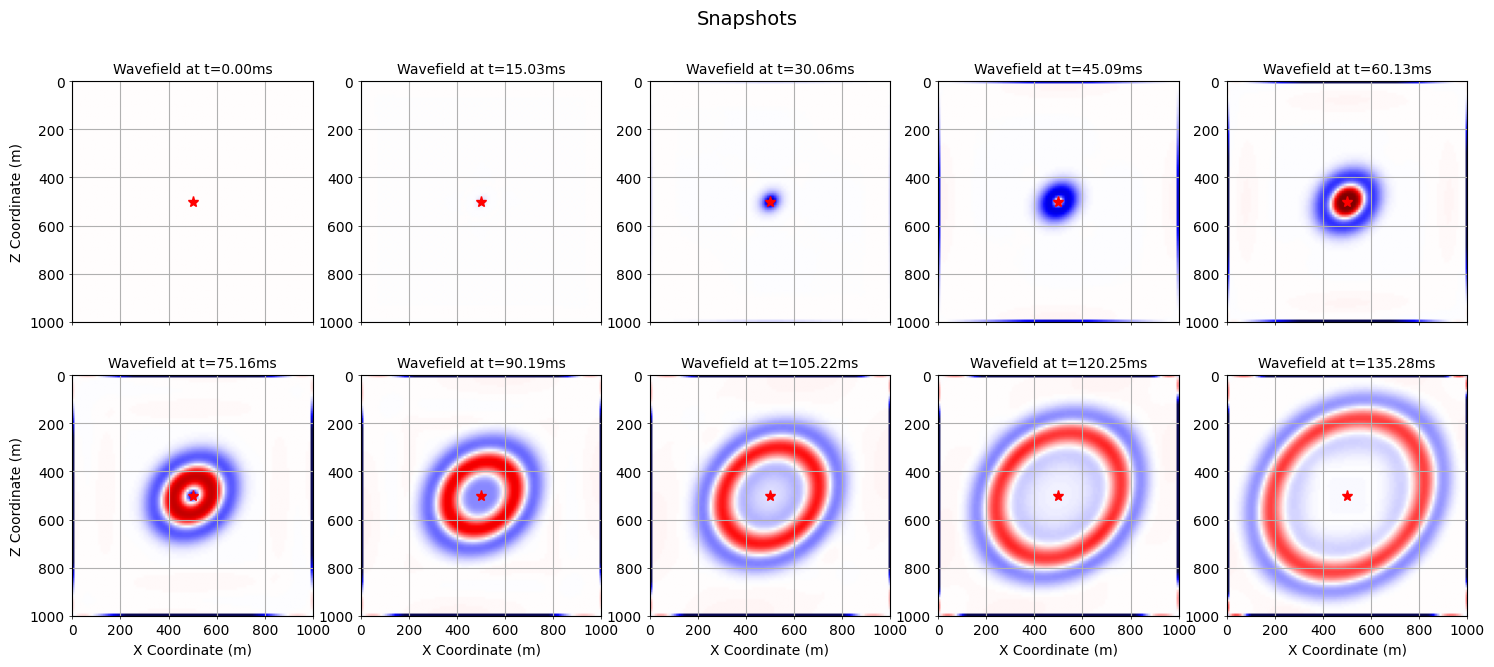

In [9]:
# NBVAL_IGNORE_OUTPUT

# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]

# Plot the wavefields, each normalized to scaled maximum of last time step
kt = (time_range.num - 2) - 1
amax = 0.05 * np.max(np.abs(psave[kt, :, :]))

nsnaps = 10
factor = round(time_range.num/nsnaps)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True)
fig.suptitle("Snapshots", size=14)
for count, ax in enumerate(axes.ravel()):
    snapshot = factor*count
    ax.imshow(np.transpose(psave[snapshot, :, :]), cmap="seismic",
               vmin=-amax, vmax=+amax, extent=plt_extent)
    ax.plot(model.domain_size[0]* .5, model.domain_size[1]* .5,
         'red', linestyle='None', marker='*', markersize=8, label="Source")
    ax.grid()
    ax.tick_params('both', length=2, width=0.5, which='major', labelsize=10)
    ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
for ax in axes[1, :]:
    ax.set_xlabel("X Coordinate (m)", fontsize=10)
for ax in axes[:, 0]:
    ax.set_ylabel("Z Coordinate (m)", fontsize=10)

## References

- **Least-squares reverse time migration in TTI media using a pure qP-wave equation** (2020)
<br> Xinru Mu, Jianping Huang, Jidong Yang, Xu Guo, and Yundong Guo
<br> Geophysics, Vol. 85, No. 4
<br> https://doi.org/10.1190/geo2019-0320.1